In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 nddf6x27


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nddf6x27:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:7.7


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                      | 1/1870 [00:00<18:32,  1.68it/s]

  0%|▍                                                                                                                     | 6/1870 [00:00<02:51, 10.87it/s]

  1%|▋                                                                                                                    | 11/1870 [00:00<01:38, 18.96it/s]

  1%|█                                                                                                                    | 16/1870 [00:00<01:12, 25.72it/s]

  1%|█▎                                                                                                                   | 21/1870 [00:01<00:59, 31.16it/s]

  1%|█▋                                                                                                                   | 26/1870 [00:01<00:52, 35.41it/s]

  2%|█▉                                                                                                                   | 31/1870 [00:01<00:47, 38.62it/s]

  2%|██▎                                                                                                                  | 36/1870 [00:01<00:44, 41.00it/s]

  2%|██▌                                                                                                                  | 41/1870 [00:01<00:42, 42.71it/s]

  2%|██▉                                                                                                                  | 46/1870 [00:01<00:41, 43.94it/s]

  3%|███▏                                                                                                                 | 51/1870 [00:01<00:40, 44.82it/s]

  3%|███▌                                                                                                                 | 56/1870 [00:01<00:39, 45.44it/s]

  3%|███▊                                                                                                                 | 61/1870 [00:01<00:39, 45.94it/s]

  4%|████▏                                                                                                                | 66/1870 [00:01<00:39, 46.23it/s]

  4%|████▍                                                                                                                | 71/1870 [00:02<00:38, 46.45it/s]

  4%|████▊                                                                                                                | 76/1870 [00:02<00:38, 46.61it/s]

  4%|█████                                                                                                                | 81/1870 [00:02<00:38, 46.74it/s]

  5%|█████▍                                                                                                               | 86/1870 [00:02<00:38, 46.88it/s]

  5%|█████▋                                                                                                               | 91/1870 [00:02<00:37, 46.95it/s]

  5%|██████                                                                                                               | 96/1870 [00:02<00:37, 47.07it/s]

  5%|██████▎                                                                                                             | 101/1870 [00:02<00:37, 47.04it/s]

  6%|██████▌                                                                                                             | 106/1870 [00:02<00:37, 47.01it/s]

  6%|██████▉                                                                                                             | 111/1870 [00:02<00:37, 47.01it/s]

  6%|███████▏                                                                                                            | 116/1870 [00:03<00:37, 46.97it/s]

  6%|███████▌                                                                                                            | 121/1870 [00:03<00:37, 46.96it/s]

  7%|███████▊                                                                                                            | 126/1870 [00:03<00:37, 46.98it/s]

  7%|████████▏                                                                                                           | 131/1870 [00:03<00:36, 47.09it/s]

  7%|████████▍                                                                                                           | 136/1870 [00:03<00:36, 47.07it/s]

  8%|████████▋                                                                                                           | 141/1870 [00:03<00:36, 47.12it/s]

  8%|█████████                                                                                                           | 146/1870 [00:03<00:36, 47.07it/s]

  8%|█████████▎                                                                                                          | 151/1870 [00:03<00:36, 47.06it/s]

  8%|█████████▋                                                                                                          | 156/1870 [00:03<00:36, 47.00it/s]

  9%|█████████▉                                                                                                          | 161/1870 [00:04<00:36, 46.99it/s]

  9%|██████████▎                                                                                                         | 166/1870 [00:04<00:36, 47.02it/s]

  9%|██████████▌                                                                                                         | 171/1870 [00:04<00:36, 47.01it/s]

  9%|██████████▉                                                                                                         | 176/1870 [00:04<00:36, 47.00it/s]

 10%|███████████▏                                                                                                        | 181/1870 [00:04<00:35, 47.00it/s]

 10%|███████████▌                                                                                                        | 186/1870 [00:04<00:35, 47.00it/s]

 10%|███████████▊                                                                                                        | 191/1870 [00:04<00:35, 47.00it/s]

 10%|████████████▏                                                                                                       | 196/1870 [00:04<00:35, 46.98it/s]

 11%|████████████▍                                                                                                       | 201/1870 [00:04<00:35, 47.01it/s]

 11%|████████████▊                                                                                                       | 206/1870 [00:04<00:35, 47.03it/s]

 11%|█████████████                                                                                                       | 211/1870 [00:05<00:35, 47.18it/s]

 12%|█████████████▍                                                                                                      | 216/1870 [00:05<00:34, 47.28it/s]

 12%|█████████████▋                                                                                                      | 221/1870 [00:05<00:34, 47.32it/s]

 12%|██████████████                                                                                                      | 226/1870 [00:05<00:34, 47.38it/s]

 12%|██████████████▎                                                                                                     | 231/1870 [00:05<00:34, 47.36it/s]

 13%|██████████████▋                                                                                                     | 236/1870 [00:05<00:34, 47.26it/s]

 13%|██████████████▉                                                                                                     | 241/1870 [00:05<00:34, 47.21it/s]

 13%|███████████████▎                                                                                                    | 246/1870 [00:05<00:34, 47.31it/s]

 13%|███████████████▌                                                                                                    | 251/1870 [00:05<00:34, 47.37it/s]

 14%|███████████████▉                                                                                                    | 256/1870 [00:06<00:34, 47.43it/s]

 14%|████████████████▏                                                                                                   | 261/1870 [00:06<00:33, 47.50it/s]

 14%|████████████████▌                                                                                                   | 266/1870 [00:06<00:33, 47.54it/s]

 14%|████████████████▊                                                                                                   | 271/1870 [00:06<00:33, 47.56it/s]

 15%|█████████████████                                                                                                   | 276/1870 [00:06<00:33, 47.47it/s]

 15%|█████████████████▍                                                                                                  | 281/1870 [00:06<00:33, 47.42it/s]

 15%|█████████████████▋                                                                                                  | 286/1870 [00:06<00:33, 47.36it/s]

 16%|██████████████████                                                                                                  | 291/1870 [00:06<00:33, 47.30it/s]

 16%|██████████████████▎                                                                                                 | 296/1870 [00:06<00:33, 47.36it/s]

 16%|██████████████████▋                                                                                                 | 301/1870 [00:06<00:33, 47.43it/s]

 16%|██████████████████▉                                                                                                 | 306/1870 [00:07<00:32, 47.49it/s]

 17%|███████████████████▎                                                                                                | 311/1870 [00:07<00:32, 47.55it/s]

 17%|███████████████████▌                                                                                                | 316/1870 [00:07<00:32, 47.46it/s]

 17%|███████████████████▉                                                                                                | 321/1870 [00:07<00:32, 47.37it/s]

 17%|████████████████████▏                                                                                               | 326/1870 [00:07<00:32, 47.48it/s]

 18%|████████████████████▌                                                                                               | 331/1870 [00:07<00:32, 47.60it/s]

 18%|████████████████████▊                                                                                               | 336/1870 [00:07<00:32, 47.67it/s]

 18%|█████████████████████▏                                                                                              | 341/1870 [00:07<00:32, 47.66it/s]

 19%|█████████████████████▍                                                                                              | 346/1870 [00:07<00:31, 47.73it/s]

 19%|█████████████████████▊                                                                                              | 351/1870 [00:08<00:31, 47.79it/s]

 19%|██████████████████████                                                                                              | 356/1870 [00:08<00:31, 47.72it/s]

 19%|██████████████████████▍                                                                                             | 361/1870 [00:08<00:31, 47.69it/s]

 20%|██████████████████████▋                                                                                             | 366/1870 [00:08<00:31, 47.70it/s]

 20%|███████████████████████                                                                                             | 371/1870 [00:08<00:31, 47.60it/s]

 20%|███████████████████████▎                                                                                            | 376/1870 [00:08<00:31, 47.68it/s]

 20%|███████████████████████▋                                                                                            | 381/1870 [00:08<00:31, 47.77it/s]

 21%|███████████████████████▉                                                                                            | 386/1870 [00:08<00:31, 47.73it/s]

 21%|████████████████████████▎                                                                                           | 391/1870 [00:08<00:31, 47.64it/s]

 21%|████████████████████████▌                                                                                           | 396/1870 [00:08<00:30, 47.65it/s]

 21%|████████████████████████▊                                                                                           | 401/1870 [00:09<00:30, 47.70it/s]

 22%|█████████████████████████▏                                                                                          | 406/1870 [00:09<00:30, 47.75it/s]

 22%|█████████████████████████▍                                                                                          | 411/1870 [00:09<00:30, 47.74it/s]

 22%|█████████████████████████▊                                                                                          | 416/1870 [00:09<00:30, 47.69it/s]

 23%|██████████████████████████                                                                                          | 421/1870 [00:09<00:30, 47.68it/s]

 23%|██████████████████████████▍                                                                                         | 426/1870 [00:09<00:30, 47.64it/s]

 23%|██████████████████████████▋                                                                                         | 431/1870 [00:09<00:30, 47.62it/s]

 23%|███████████████████████████                                                                                         | 436/1870 [00:09<00:30, 47.61it/s]

 24%|███████████████████████████▎                                                                                        | 441/1870 [00:09<00:30, 47.62it/s]

 24%|███████████████████████████▋                                                                                        | 446/1870 [00:10<00:29, 47.65it/s]

 24%|███████████████████████████▉                                                                                        | 451/1870 [00:10<00:29, 47.62it/s]

 24%|████████████████████████████▎                                                                                       | 456/1870 [00:10<00:29, 47.44it/s]

 25%|████████████████████████████▌                                                                                       | 461/1870 [00:10<00:29, 47.37it/s]

 25%|████████████████████████████▉                                                                                       | 466/1870 [00:10<00:29, 47.33it/s]

 25%|█████████████████████████████▏                                                                                      | 471/1870 [00:10<00:29, 47.40it/s]

 25%|█████████████████████████████▌                                                                                      | 476/1870 [00:10<00:29, 47.44it/s]

 26%|█████████████████████████████▊                                                                                      | 481/1870 [00:10<00:29, 47.50it/s]

 26%|██████████████████████████████▏                                                                                     | 486/1870 [00:10<00:29, 47.54it/s]

 26%|██████████████████████████████▍                                                                                     | 491/1870 [00:10<00:29, 47.52it/s]

 27%|██████████████████████████████▊                                                                                     | 496/1870 [00:11<00:28, 47.45it/s]

 27%|███████████████████████████████                                                                                     | 501/1870 [00:11<00:28, 47.39it/s]

 27%|███████████████████████████████▍                                                                                    | 506/1870 [00:11<00:28, 47.34it/s]

 27%|███████████████████████████████▋                                                                                    | 511/1870 [00:11<00:28, 47.36it/s]

 28%|████████████████████████████████                                                                                    | 516/1870 [00:11<00:28, 47.46it/s]

 28%|████████████████████████████████▎                                                                                   | 521/1870 [00:11<00:28, 47.41it/s]

 28%|████████████████████████████████▋                                                                                   | 526/1870 [00:11<00:28, 47.50it/s]

 28%|████████████████████████████████▉                                                                                   | 531/1870 [00:11<00:28, 47.45it/s]

 29%|█████████████████████████████████▏                                                                                  | 536/1870 [00:11<00:28, 47.41it/s]

 29%|█████████████████████████████████▌                                                                                  | 541/1870 [00:12<00:28, 47.44it/s]

 29%|█████████████████████████████████▊                                                                                  | 546/1870 [00:12<00:27, 47.47it/s]

 29%|██████████████████████████████████▏                                                                                 | 551/1870 [00:12<00:27, 47.50it/s]

 30%|██████████████████████████████████▍                                                                                 | 556/1870 [00:12<00:27, 47.55it/s]

 30%|██████████████████████████████████▊                                                                                 | 561/1870 [00:12<00:27, 47.52it/s]

 30%|███████████████████████████████████                                                                                 | 566/1870 [00:12<00:27, 47.54it/s]

 31%|███████████████████████████████████▍                                                                                | 571/1870 [00:12<00:27, 47.52it/s]

 31%|███████████████████████████████████▋                                                                                | 576/1870 [00:12<00:27, 47.44it/s]

 31%|████████████████████████████████████                                                                                | 581/1870 [00:12<00:27, 47.45it/s]

 31%|████████████████████████████████████▎                                                                               | 586/1870 [00:12<00:27, 47.40it/s]

 32%|████████████████████████████████████▋                                                                               | 591/1870 [00:13<00:26, 47.41it/s]

 32%|████████████████████████████████████▉                                                                               | 596/1870 [00:13<00:26, 47.41it/s]

 32%|█████████████████████████████████████▎                                                                              | 601/1870 [00:13<00:26, 47.45it/s]

 32%|█████████████████████████████████████▌                                                                              | 606/1870 [00:13<00:26, 47.48it/s]

 33%|█████████████████████████████████████▉                                                                              | 611/1870 [00:13<00:26, 47.54it/s]

 33%|██████████████████████████████████████▏                                                                             | 616/1870 [00:13<00:26, 47.50it/s]

 33%|██████████████████████████████████████▌                                                                             | 621/1870 [00:13<00:26, 47.46it/s]

 33%|██████████████████████████████████████▊                                                                             | 626/1870 [00:13<00:26, 47.45it/s]

 34%|███████████████████████████████████████▏                                                                            | 631/1870 [00:13<00:26, 47.46it/s]

 34%|███████████████████████████████████████▍                                                                            | 636/1870 [00:14<00:25, 47.49it/s]

 34%|███████████████████████████████████████▊                                                                            | 641/1870 [00:14<00:25, 47.49it/s]

 35%|████████████████████████████████████████                                                                            | 646/1870 [00:14<00:25, 47.36it/s]

 35%|████████████████████████████████████████▍                                                                           | 651/1870 [00:14<00:25, 47.36it/s]

 35%|████████████████████████████████████████▋                                                                           | 656/1870 [00:14<00:25, 47.37it/s]

 35%|█████████████████████████████████████████                                                                           | 661/1870 [00:14<00:25, 47.29it/s]

 36%|█████████████████████████████████████████▎                                                                          | 666/1870 [00:14<00:25, 47.30it/s]

 36%|█████████████████████████████████████████▌                                                                          | 671/1870 [00:14<00:25, 47.35it/s]

 36%|█████████████████████████████████████████▉                                                                          | 676/1870 [00:14<00:25, 47.34it/s]

 36%|██████████████████████████████████████████▏                                                                         | 681/1870 [00:14<00:25, 47.36it/s]

 37%|██████████████████████████████████████████▌                                                                         | 686/1870 [00:15<00:24, 47.41it/s]

 37%|██████████████████████████████████████████▊                                                                         | 691/1870 [00:15<00:24, 47.48it/s]

 37%|███████████████████████████████████████████▏                                                                        | 696/1870 [00:15<00:24, 47.49it/s]

 37%|███████████████████████████████████████████▍                                                                        | 701/1870 [00:15<00:24, 47.39it/s]

 38%|███████████████████████████████████████████▊                                                                        | 706/1870 [00:15<00:24, 47.38it/s]

 38%|████████████████████████████████████████████                                                                        | 711/1870 [00:15<00:24, 47.34it/s]

 38%|████████████████████████████████████████████▍                                                                       | 716/1870 [00:15<00:24, 47.93it/s]

 39%|████████████████████████████████████████████▋                                                                       | 721/1870 [00:15<00:23, 48.37it/s]

 39%|█████████████████████████████████████████████                                                                       | 726/1870 [00:15<00:23, 48.68it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 731/1870 [00:15<00:23, 48.78it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 736/1870 [00:16<00:23, 48.88it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 741/1870 [00:16<00:23, 49.03it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 746/1870 [00:16<00:22, 49.08it/s]

 40%|██████████████████████████████████████████████▌                                                                     | 751/1870 [00:16<00:22, 49.14it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 756/1870 [00:16<00:22, 49.22it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 761/1870 [00:16<00:22, 49.26it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 766/1870 [00:16<00:22, 49.31it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 771/1870 [00:16<00:22, 49.35it/s]

 41%|████████████████████████████████████████████████▏                                                                   | 776/1870 [00:16<00:22, 49.36it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 781/1870 [00:17<00:22, 49.35it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 786/1870 [00:17<00:21, 49.37it/s]

 42%|█████████████████████████████████████████████████                                                                   | 791/1870 [00:17<00:21, 49.33it/s]

 43%|█████████████████████████████████████████████████▍                                                                  | 796/1870 [00:17<00:21, 49.32it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 801/1870 [00:17<00:21, 49.37it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 806/1870 [00:17<00:21, 49.40it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 811/1870 [00:17<00:21, 49.40it/s]

 44%|██████████████████████████████████████████████████▌                                                                 | 816/1870 [00:17<00:21, 49.40it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 821/1870 [00:17<00:21, 49.30it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 826/1870 [00:17<00:21, 49.30it/s]

 44%|███████████████████████████████████████████████████▌                                                                | 831/1870 [00:18<00:21, 49.28it/s]

 45%|███████████████████████████████████████████████████▊                                                                | 836/1870 [00:18<00:20, 49.31it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 841/1870 [00:18<00:20, 49.32it/s]

 45%|████████████████████████████████████████████████████▍                                                               | 846/1870 [00:18<00:20, 49.36it/s]

 46%|████████████████████████████████████████████████████▊                                                               | 851/1870 [00:18<00:20, 49.34it/s]

 46%|█████████████████████████████████████████████████████                                                               | 856/1870 [00:18<00:20, 49.35it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 861/1870 [00:18<00:20, 49.31it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 866/1870 [00:18<00:20, 49.34it/s]

 47%|██████████████████████████████████████████████████████                                                              | 871/1870 [00:18<00:20, 49.35it/s]

 47%|██████████████████████████████████████████████████████▎                                                             | 876/1870 [00:18<00:20, 49.35it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 881/1870 [00:19<00:20, 49.33it/s]

 47%|██████████████████████████████████████████████████████▉                                                             | 886/1870 [00:19<00:19, 49.29it/s]

 48%|███████████████████████████████████████████████████████▎                                                            | 891/1870 [00:19<00:19, 49.29it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 896/1870 [00:19<00:19, 49.31it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 901/1870 [00:19<00:19, 49.34it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 906/1870 [00:19<00:19, 49.35it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 911/1870 [00:19<00:19, 49.38it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 916/1870 [00:19<00:19, 49.34it/s]

 49%|█████████████████████████████████████████████████████████▏                                                          | 921/1870 [00:19<00:19, 49.24it/s]

 50%|█████████████████████████████████████████████████████████▍                                                          | 926/1870 [00:19<00:19, 49.29it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 931/1870 [00:20<00:19, 49.28it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 936/1870 [00:20<00:18, 49.31it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 941/1870 [00:20<00:18, 49.31it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 946/1870 [00:20<00:18, 49.29it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 951/1870 [00:20<00:18, 49.31it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 956/1870 [00:20<00:18, 49.31it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 961/1870 [00:20<00:18, 49.35it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 966/1870 [00:20<00:18, 49.38it/s]

 52%|████████████████████████████████████████████████████████████▏                                                       | 971/1870 [00:20<00:18, 49.36it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 976/1870 [00:20<00:18, 49.33it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 981/1870 [00:21<00:18, 49.36it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 986/1870 [00:21<00:17, 49.33it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 991/1870 [00:21<00:17, 49.36it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 996/1870 [00:21<00:17, 49.39it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1001/1870 [00:21<00:17, 49.40it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1006/1870 [00:21<00:17, 49.40it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1011/1870 [00:21<00:17, 49.32it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1016/1870 [00:21<00:17, 49.31it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1021/1870 [00:21<00:17, 49.33it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1026/1870 [00:21<00:17, 49.34it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1031/1870 [00:22<00:16, 49.36it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1036/1870 [00:22<00:16, 49.37it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1041/1870 [00:22<00:16, 49.27it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1046/1870 [00:22<00:16, 49.30it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1051/1870 [00:22<00:16, 49.35it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1056/1870 [00:22<00:16, 49.41it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1061/1870 [00:22<00:16, 49.43it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1066/1870 [00:22<00:16, 49.39it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1071/1870 [00:22<00:16, 49.42it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1076/1870 [00:22<00:16, 49.45it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1081/1870 [00:23<00:16, 47.98it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1086/1870 [00:23<00:16, 48.41it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1091/1870 [00:23<00:16, 48.67it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1096/1870 [00:23<00:15, 48.87it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1101/1870 [00:23<00:15, 49.05it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1106/1870 [00:23<00:15, 49.16it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1111/1870 [00:23<00:15, 49.27it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1116/1870 [00:23<00:15, 49.36it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1121/1870 [00:23<00:15, 49.40it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1126/1870 [00:24<00:15, 49.41it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 1131/1870 [00:24<00:14, 49.40it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1136/1870 [00:24<00:14, 49.36it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1141/1870 [00:24<00:14, 49.32it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1146/1870 [00:24<00:14, 49.35it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1151/1870 [00:24<00:14, 49.34it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1156/1870 [00:24<00:14, 49.37it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1161/1870 [00:24<00:14, 49.38it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1166/1870 [00:24<00:14, 49.38it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1171/1870 [00:24<00:14, 49.22it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1176/1870 [00:25<00:14, 49.26it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1181/1870 [00:25<00:13, 49.32it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1186/1870 [00:25<00:13, 49.34it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1191/1870 [00:25<00:13, 49.36it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1196/1870 [00:25<00:13, 49.35it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1201/1870 [00:25<00:13, 49.35it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                        | 1206/1870 [00:25<00:13, 49.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1211/1870 [00:25<00:13, 49.40it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1216/1870 [00:25<00:13, 49.44it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1221/1870 [00:25<00:13, 49.44it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1226/1870 [00:26<00:13, 49.45it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1231/1870 [00:26<00:12, 49.47it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1236/1870 [00:26<00:12, 49.46it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1241/1870 [00:26<00:12, 49.22it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1246/1870 [00:26<00:12, 48.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1251/1870 [00:26<00:12, 48.41it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1256/1870 [00:26<00:12, 48.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1261/1870 [00:26<00:12, 47.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1266/1870 [00:26<00:12, 47.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1271/1870 [00:26<00:12, 47.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 1276/1870 [00:27<00:12, 47.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 1281/1870 [00:27<00:12, 47.69it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 1286/1870 [00:27<00:12, 47.66it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 1291/1870 [00:27<00:12, 47.63it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 1296/1870 [00:27<00:12, 47.63it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 1301/1870 [00:27<00:11, 47.62it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 1306/1870 [00:27<00:11, 47.61it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 1311/1870 [00:27<00:11, 47.60it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 1316/1870 [00:27<00:11, 47.49it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 1321/1870 [00:28<00:11, 47.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 1326/1870 [00:28<00:11, 47.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 1331/1870 [00:28<00:11, 47.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 1336/1870 [00:28<00:11, 47.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 1341/1870 [00:28<00:11, 47.58it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 1346/1870 [00:28<00:11, 47.59it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 1351/1870 [00:28<00:10, 47.57it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 1356/1870 [00:28<00:10, 47.58it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 1361/1870 [00:28<00:10, 47.60it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 1366/1870 [00:28<00:10, 47.60it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 1371/1870 [00:29<00:10, 47.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 1376/1870 [00:29<00:10, 47.50it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 1381/1870 [00:29<00:10, 47.50it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 1386/1870 [00:29<00:10, 47.52it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 1391/1870 [00:29<00:10, 47.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 1396/1870 [00:29<00:09, 47.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 1401/1870 [00:29<00:09, 47.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 1406/1870 [00:29<00:09, 47.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 1411/1870 [00:29<00:09, 47.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 1416/1870 [00:30<00:09, 47.45it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 1421/1870 [00:30<00:09, 47.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 1426/1870 [00:30<00:09, 47.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 1431/1870 [00:30<00:09, 47.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 1436/1870 [00:30<00:09, 47.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 1441/1870 [00:30<00:09, 47.59it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 1446/1870 [00:30<00:08, 47.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 1451/1870 [00:30<00:08, 47.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 1456/1870 [00:30<00:08, 47.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 1461/1870 [00:30<00:08, 47.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 1466/1870 [00:31<00:08, 47.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 1471/1870 [00:31<00:08, 47.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 1476/1870 [00:31<00:08, 47.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 1481/1870 [00:31<00:08, 47.48it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 1486/1870 [00:31<00:08, 47.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 1491/1870 [00:31<00:07, 47.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 1496/1870 [00:31<00:07, 47.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1501/1870 [00:31<00:07, 47.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1506/1870 [00:31<00:07, 47.51it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1511/1870 [00:32<00:07, 47.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1516/1870 [00:32<00:07, 47.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1521/1870 [00:32<00:07, 47.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1526/1870 [00:32<00:07, 47.57it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1531/1870 [00:32<00:07, 47.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1536/1870 [00:32<00:07, 47.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1541/1870 [00:32<00:06, 47.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 1546/1870 [00:32<00:06, 47.50it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1551/1870 [00:32<00:06, 47.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1556/1870 [00:32<00:06, 47.46it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1561/1870 [00:33<00:06, 47.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1566/1870 [00:33<00:06, 47.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1571/1870 [00:33<00:06, 47.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1576/1870 [00:33<00:06, 47.47it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1581/1870 [00:33<00:06, 47.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1586/1870 [00:33<00:05, 47.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1591/1870 [00:33<00:05, 47.42it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1596/1870 [00:33<00:05, 47.45it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1601/1870 [00:33<00:05, 47.47it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1606/1870 [00:34<00:05, 47.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 1611/1870 [00:34<00:05, 47.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1616/1870 [00:34<00:05, 47.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1621/1870 [00:34<00:05, 47.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1626/1870 [00:34<00:05, 47.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1631/1870 [00:34<00:05, 47.37it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1636/1870 [00:34<00:04, 47.36it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1641/1870 [00:34<00:04, 47.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1646/1870 [00:34<00:04, 47.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1651/1870 [00:34<00:04, 47.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1656/1870 [00:35<00:04, 47.70it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1661/1870 [00:35<00:04, 47.66it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1666/1870 [00:35<00:04, 47.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1671/1870 [00:35<00:04, 47.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 1676/1870 [00:35<00:04, 47.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1681/1870 [00:35<00:03, 47.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1686/1870 [00:35<00:03, 47.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1691/1870 [00:35<00:03, 47.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1696/1870 [00:35<00:03, 47.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1701/1870 [00:36<00:03, 47.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1706/1870 [00:36<00:03, 47.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1711/1870 [00:36<00:03, 47.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1716/1870 [00:36<00:03, 47.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1721/1870 [00:36<00:03, 47.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1726/1870 [00:36<00:03, 47.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1731/1870 [00:36<00:02, 47.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1736/1870 [00:36<00:02, 47.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1741/1870 [00:36<00:02, 47.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1746/1870 [00:36<00:02, 47.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1751/1870 [00:37<00:02, 47.75it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1756/1870 [00:37<00:02, 47.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1761/1870 [00:37<00:02, 47.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1766/1870 [00:37<00:02, 47.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1771/1870 [00:37<00:02, 47.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1776/1870 [00:37<00:01, 47.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1781/1870 [00:37<00:01, 47.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1786/1870 [00:37<00:01, 47.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1791/1870 [00:37<00:01, 47.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1796/1870 [00:38<00:01, 47.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1801/1870 [00:38<00:01, 47.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1806/1870 [00:38<00:01, 47.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1811/1870 [00:38<00:01, 47.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1816/1870 [00:38<00:01, 47.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1821/1870 [00:38<00:01, 47.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1826/1870 [00:38<00:00, 47.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1831/1870 [00:38<00:00, 47.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1836/1870 [00:38<00:00, 47.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1841/1870 [00:38<00:00, 47.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1846/1870 [00:39<00:00, 47.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1851/1870 [00:39<00:00, 47.51it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1856/1870 [00:39<00:00, 47.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1861/1870 [00:39<00:00, 47.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1866/1870 [00:39<00:00, 47.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:39<00:00, 47.11it/s]

train - OK


  0%|                                                                                                                               | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/468 [00:00<02:21,  3.30it/s]

  1%|█▌                                                                                                                     | 6/468 [00:00<00:26, 17.60it/s]

  2%|██▊                                                                                                                   | 11/468 [00:00<00:16, 26.98it/s]

  3%|████                                                                                                                  | 16/468 [00:00<00:13, 33.35it/s]

  4%|█████▎                                                                                                                | 21/468 [00:00<00:11, 37.69it/s]

  6%|██████▌                                                                                                               | 26/468 [00:00<00:10, 40.69it/s]

  7%|███████▊                                                                                                              | 31/468 [00:00<00:10, 42.72it/s]

  8%|█████████                                                                                                             | 36/468 [00:01<00:09, 44.16it/s]

  9%|██████████▎                                                                                                           | 41/468 [00:01<00:09, 45.08it/s]

 10%|███████████▌                                                                                                          | 46/468 [00:01<00:09, 45.71it/s]

 11%|████████████▊                                                                                                         | 51/468 [00:01<00:09, 46.17it/s]

 12%|██████████████                                                                                                        | 56/468 [00:01<00:08, 46.55it/s]

 13%|███████████████▍                                                                                                      | 61/468 [00:01<00:08, 46.79it/s]

 14%|████████████████▋                                                                                                     | 66/468 [00:01<00:08, 46.90it/s]

 15%|█████████████████▉                                                                                                    | 71/468 [00:01<00:08, 47.03it/s]

 16%|███████████████████▏                                                                                                  | 76/468 [00:01<00:08, 47.11it/s]

 17%|████████████████████▍                                                                                                 | 81/468 [00:01<00:08, 47.22it/s]

 18%|█████████████████████▋                                                                                                | 86/468 [00:02<00:08, 47.25it/s]

 19%|██████████████████████▉                                                                                               | 91/468 [00:02<00:07, 47.29it/s]

 21%|████████████████████████▏                                                                                             | 96/468 [00:02<00:07, 47.34it/s]

 22%|█████████████████████████▎                                                                                           | 101/468 [00:02<00:07, 47.38it/s]

 23%|██████████████████████████▌                                                                                          | 106/468 [00:02<00:07, 47.40it/s]

 24%|███████████████████████████▊                                                                                         | 111/468 [00:02<00:07, 47.43it/s]

 25%|█████████████████████████████                                                                                        | 116/468 [00:02<00:07, 47.48it/s]

 26%|██████████████████████████████▎                                                                                      | 121/468 [00:02<00:07, 47.44it/s]

 27%|███████████████████████████████▌                                                                                     | 126/468 [00:02<00:07, 47.42it/s]

 28%|████████████████████████████████▊                                                                                    | 131/468 [00:03<00:07, 47.37it/s]

 29%|██████████████████████████████████                                                                                   | 136/468 [00:03<00:07, 47.38it/s]

 30%|███████████████████████████████████▎                                                                                 | 141/468 [00:03<00:06, 47.41it/s]

 31%|████████████████████████████████████▌                                                                                | 146/468 [00:03<00:06, 47.39it/s]

 32%|█████████████████████████████████████▊                                                                               | 151/468 [00:03<00:06, 47.40it/s]

 33%|███████████████████████████████████████                                                                              | 156/468 [00:03<00:06, 47.44it/s]

 34%|████████████████████████████████████████▎                                                                            | 161/468 [00:03<00:06, 47.41it/s]

 35%|█████████████████████████████████████████▌                                                                           | 166/468 [00:03<00:06, 47.40it/s]

 37%|██████████████████████████████████████████▊                                                                          | 171/468 [00:03<00:06, 47.32it/s]

 38%|████████████████████████████████████████████                                                                         | 176/468 [00:04<00:06, 47.33it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 181/468 [00:04<00:06, 47.39it/s]

 40%|██████████████████████████████████████████████▌                                                                      | 186/468 [00:04<00:05, 47.31it/s]

 41%|███████████████████████████████████████████████▊                                                                     | 191/468 [00:04<00:05, 47.29it/s]

 42%|█████████████████████████████████████████████████                                                                    | 196/468 [00:04<00:05, 47.23it/s]

 43%|██████████████████████████████████████████████████▎                                                                  | 201/468 [00:04<00:05, 47.27it/s]

 44%|███████████████████████████████████████████████████▌                                                                 | 206/468 [00:04<00:05, 47.33it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 211/468 [00:04<00:05, 47.34it/s]

 46%|██████████████████████████████████████████████████████                                                               | 216/468 [00:04<00:05, 47.32it/s]

 47%|███████████████████████████████████████████████████████▎                                                             | 221/468 [00:04<00:05, 47.36it/s]

 48%|████████████████████████████████████████████████████████▌                                                            | 226/468 [00:05<00:05, 47.39it/s]

 49%|█████████████████████████████████████████████████████████▊                                                           | 231/468 [00:05<00:05, 47.37it/s]

 50%|███████████████████████████████████████████████████████████                                                          | 236/468 [00:05<00:04, 47.35it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 241/468 [00:05<00:04, 47.37it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 246/468 [00:05<00:04, 47.41it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                      | 251/468 [00:05<00:04, 47.36it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 256/468 [00:05<00:04, 47.38it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 261/468 [00:05<00:04, 47.32it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 266/468 [00:05<00:04, 47.27it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 271/468 [00:06<00:04, 47.28it/s]

 59%|█████████████████████████████████████████████████████████████████████                                                | 276/468 [00:06<00:04, 47.35it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 281/468 [00:06<00:03, 47.38it/s]

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 286/468 [00:06<00:03, 47.43it/s]

 62%|████████████████████████████████████████████████████████████████████████▊                                            | 291/468 [00:06<00:03, 47.42it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 296/468 [00:06<00:03, 47.31it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 301/468 [00:06<00:03, 47.29it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 306/468 [00:06<00:03, 47.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 311/468 [00:06<00:03, 47.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 316/468 [00:06<00:03, 47.33it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 321/468 [00:07<00:03, 47.37it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 326/468 [00:07<00:02, 47.37it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 331/468 [00:07<00:02, 47.36it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 336/468 [00:07<00:02, 47.35it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 341/468 [00:07<00:02, 47.40it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 346/468 [00:07<00:02, 47.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 351/468 [00:07<00:02, 47.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████                            | 356/468 [00:07<00:02, 47.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                          | 361/468 [00:07<00:02, 47.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 366/468 [00:08<00:02, 47.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 371/468 [00:08<00:02, 47.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 376/468 [00:08<00:01, 47.42it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 381/468 [00:08<00:01, 47.38it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 386/468 [00:08<00:01, 47.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 391/468 [00:08<00:01, 47.38it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 396/468 [00:08<00:01, 47.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 401/468 [00:08<00:01, 47.36it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 406/468 [00:08<00:01, 47.34it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 411/468 [00:08<00:01, 47.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 416/468 [00:09<00:01, 47.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 421/468 [00:09<00:00, 47.42it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 426/468 [00:09<00:00, 47.47it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 431/468 [00:09<00:00, 47.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 436/468 [00:09<00:00, 47.42it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 441/468 [00:09<00:00, 47.37it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 446/468 [00:09<00:00, 47.30it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 451/468 [00:09<00:00, 47.30it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 456/468 [00:09<00:00, 47.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 461/468 [00:10<00:00, 47.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 466/468 [00:10<00:00, 47.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 45.39it/s]

val - OK


  0%|                                                                                                                               | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                      | 1/764 [00:00<04:33,  2.78it/s]

  1%|▉                                                                                                                      | 6/764 [00:00<00:47, 15.81it/s]

  1%|█▋                                                                                                                    | 11/764 [00:00<00:29, 25.15it/s]

  2%|██▍                                                                                                                   | 16/764 [00:00<00:23, 31.81it/s]

  3%|███▏                                                                                                                  | 21/764 [00:00<00:20, 36.52it/s]

  3%|████                                                                                                                  | 26/764 [00:00<00:18, 39.81it/s]

  4%|████▊                                                                                                                 | 31/764 [00:00<00:17, 42.19it/s]

  5%|█████▌                                                                                                                | 36/764 [00:01<00:16, 43.90it/s]

  5%|██████▎                                                                                                               | 41/764 [00:01<00:16, 45.10it/s]

  6%|███████                                                                                                               | 46/764 [00:01<00:15, 45.88it/s]

  7%|███████▉                                                                                                              | 51/764 [00:01<00:15, 46.41it/s]

  7%|████████▋                                                                                                             | 56/764 [00:01<00:15, 46.84it/s]

  8%|█████████▍                                                                                                            | 61/764 [00:01<00:14, 47.12it/s]

  9%|██████████▏                                                                                                           | 66/764 [00:01<00:14, 47.32it/s]

  9%|██████████▉                                                                                                           | 71/764 [00:01<00:14, 47.49it/s]

 10%|███████████▋                                                                                                          | 76/764 [00:01<00:14, 47.59it/s]

 11%|████████████▌                                                                                                         | 81/764 [00:02<00:14, 47.71it/s]

 11%|█████████████▎                                                                                                        | 86/764 [00:02<00:14, 47.68it/s]

 12%|██████████████                                                                                                        | 91/764 [00:02<00:14, 47.72it/s]

 13%|██████████████▊                                                                                                       | 96/764 [00:02<00:14, 47.71it/s]

 13%|███████████████▍                                                                                                     | 101/764 [00:02<00:13, 47.78it/s]

 14%|████████████████▏                                                                                                    | 106/764 [00:02<00:13, 47.76it/s]

 15%|████████████████▉                                                                                                    | 111/764 [00:02<00:13, 47.74it/s]

 15%|█████████████████▊                                                                                                   | 116/764 [00:02<00:13, 47.77it/s]

 16%|██████████████████▌                                                                                                  | 121/764 [00:02<00:13, 47.81it/s]

 16%|███████████████████▎                                                                                                 | 126/764 [00:02<00:13, 47.72it/s]

 17%|████████████████████                                                                                                 | 131/764 [00:03<00:13, 47.79it/s]

 18%|████████████████████▊                                                                                                | 136/764 [00:03<00:13, 47.75it/s]

 18%|█████████████████████▌                                                                                               | 141/764 [00:03<00:13, 47.80it/s]

 19%|██████████████████████▎                                                                                              | 146/764 [00:03<00:12, 47.83it/s]

 20%|███████████████████████                                                                                              | 151/764 [00:03<00:12, 47.83it/s]

 20%|███████████████████████▉                                                                                             | 156/764 [00:03<00:12, 47.80it/s]

 21%|████████████████████████▋                                                                                            | 161/764 [00:03<00:12, 47.82it/s]

 22%|█████████████████████████▍                                                                                           | 166/764 [00:03<00:12, 47.79it/s]

 22%|██████████████████████████▏                                                                                          | 171/764 [00:03<00:12, 46.54it/s]

 23%|██████████████████████████▉                                                                                          | 176/764 [00:04<00:12, 46.94it/s]

 24%|███████████████████████████▋                                                                                         | 181/764 [00:04<00:12, 47.21it/s]

 24%|████████████████████████████▍                                                                                        | 186/764 [00:04<00:12, 47.41it/s]

 25%|█████████████████████████████▎                                                                                       | 191/764 [00:04<00:12, 47.52it/s]

 26%|██████████████████████████████                                                                                       | 196/764 [00:04<00:11, 47.59it/s]

 26%|██████████████████████████████▊                                                                                      | 201/764 [00:04<00:11, 47.60it/s]

 27%|███████████████████████████████▌                                                                                     | 206/764 [00:04<00:11, 47.67it/s]

 28%|████████████████████████████████▎                                                                                    | 211/764 [00:04<00:11, 47.70it/s]

 28%|█████████████████████████████████                                                                                    | 216/764 [00:04<00:11, 47.81it/s]

 29%|█████████████████████████████████▊                                                                                   | 221/764 [00:04<00:11, 47.81it/s]

 30%|██████████████████████████████████▌                                                                                  | 226/764 [00:05<00:11, 47.80it/s]

 30%|███████████████████████████████████▍                                                                                 | 231/764 [00:05<00:11, 47.84it/s]

 31%|████████████████████████████████████▏                                                                                | 236/764 [00:05<00:11, 47.84it/s]

 32%|████████████████████████████████████▉                                                                                | 241/764 [00:05<00:10, 47.81it/s]

 32%|█████████████████████████████████████▋                                                                               | 246/764 [00:05<00:10, 47.77it/s]

 33%|██████████████████████████████████████▍                                                                              | 251/764 [00:05<00:10, 47.68it/s]

 34%|███████████████████████████████████████▏                                                                             | 256/764 [00:05<00:10, 47.74it/s]

 34%|███████████████████████████████████████▉                                                                             | 261/764 [00:05<00:10, 47.81it/s]

 35%|████████████████████████████████████████▋                                                                            | 266/764 [00:05<00:10, 47.86it/s]

 35%|█████████████████████████████████████████▌                                                                           | 271/764 [00:06<00:10, 47.91it/s]

 36%|██████████████████████████████████████████▎                                                                          | 276/764 [00:06<00:10, 47.84it/s]

 37%|███████████████████████████████████████████                                                                          | 281/764 [00:06<00:10, 47.75it/s]

 37%|███████████████████████████████████████████▊                                                                         | 286/764 [00:06<00:10, 47.76it/s]

 38%|████████████████████████████████████████████▌                                                                        | 291/764 [00:06<00:09, 47.77it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 296/764 [00:06<00:09, 47.76it/s]

 39%|██████████████████████████████████████████████                                                                       | 301/764 [00:06<00:09, 47.79it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 306/764 [00:06<00:09, 47.87it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 311/764 [00:06<00:09, 47.91it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 316/764 [00:06<00:09, 47.86it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 321/764 [00:07<00:09, 47.81it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 326/764 [00:07<00:09, 47.77it/s]

 43%|██████████████████████████████████████████████████▋                                                                  | 331/764 [00:07<00:09, 47.76it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 336/764 [00:07<00:08, 47.80it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 341/764 [00:07<00:08, 47.82it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 346/764 [00:07<00:08, 47.86it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 351/764 [00:07<00:08, 47.83it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 356/764 [00:07<00:08, 47.88it/s]

 47%|███████████████████████████████████████████████████████▎                                                             | 361/764 [00:07<00:08, 47.84it/s]

 48%|████████████████████████████████████████████████████████                                                             | 366/764 [00:08<00:08, 47.78it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 371/764 [00:08<00:08, 47.79it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 376/764 [00:08<00:08, 47.78it/s]

 50%|██████████████████████████████████████████████████████████▎                                                          | 381/764 [00:08<00:08, 47.77it/s]

 51%|███████████████████████████████████████████████████████████                                                          | 386/764 [00:08<00:07, 47.82it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 391/764 [00:08<00:07, 47.87it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 396/764 [00:08<00:07, 47.84it/s]

 52%|█████████████████████████████████████████████████████████████▍                                                       | 401/764 [00:08<00:07, 47.83it/s]

 53%|██████████████████████████████████████████████████████████████▏                                                      | 406/764 [00:08<00:07, 47.82it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                      | 411/764 [00:08<00:07, 47.81it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 416/764 [00:09<00:07, 47.79it/s]

 55%|████████████████████████████████████████████████████████████████▍                                                    | 421/764 [00:09<00:07, 47.72it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                   | 426/764 [00:09<00:07, 47.68it/s]

 56%|██████████████████████████████████████████████████████████████████                                                   | 431/764 [00:09<00:06, 47.72it/s]

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 436/764 [00:09<00:06, 47.76it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                 | 441/764 [00:09<00:06, 47.74it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 446/764 [00:09<00:06, 47.79it/s]

 59%|█████████████████████████████████████████████████████████████████████                                                | 451/764 [00:09<00:06, 47.84it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                               | 456/764 [00:09<00:06, 47.82it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 461/764 [00:09<00:06, 47.80it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 466/764 [00:10<00:06, 47.72it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                            | 471/764 [00:10<00:06, 47.68it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 476/764 [00:10<00:06, 47.73it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 481/764 [00:10<00:05, 47.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 486/764 [00:10<00:05, 47.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 491/764 [00:10<00:05, 47.72it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 496/764 [00:10<00:05, 47.79it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 501/764 [00:10<00:05, 47.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 506/764 [00:10<00:05, 47.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▎                                      | 511/764 [00:11<00:05, 47.70it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 516/764 [00:11<00:05, 47.72it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 521/764 [00:11<00:05, 47.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 526/764 [00:11<00:04, 47.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 531/764 [00:11<00:04, 47.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 536/764 [00:11<00:04, 47.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 541/764 [00:11<00:04, 47.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 546/764 [00:11<00:04, 47.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▍                                | 551/764 [00:11<00:04, 47.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 556/764 [00:11<00:04, 47.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 561/764 [00:12<00:04, 47.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 566/764 [00:12<00:04, 47.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 571/764 [00:12<00:04, 47.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 576/764 [00:12<00:03, 47.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 581/764 [00:12<00:03, 47.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 586/764 [00:12<00:03, 47.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 591/764 [00:12<00:03, 47.74it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 596/764 [00:12<00:03, 47.70it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 601/764 [00:12<00:03, 47.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 606/764 [00:13<00:03, 47.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 611/764 [00:13<00:03, 47.83it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 616/764 [00:13<00:03, 47.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 621/764 [00:13<00:02, 47.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 626/764 [00:13<00:02, 47.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 631/764 [00:13<00:02, 47.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 636/764 [00:13<00:02, 47.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 641/764 [00:13<00:02, 47.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 646/764 [00:13<00:02, 47.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 651/764 [00:13<00:02, 47.76it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 656/764 [00:14<00:02, 47.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 661/764 [00:14<00:02, 47.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 666/764 [00:14<00:02, 47.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 671/764 [00:14<00:01, 47.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 676/764 [00:14<00:01, 47.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 681/764 [00:14<00:01, 47.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 686/764 [00:14<00:01, 47.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 691/764 [00:14<00:01, 47.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 696/764 [00:14<00:01, 47.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 701/764 [00:15<00:01, 47.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 706/764 [00:15<00:01, 47.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 711/764 [00:15<00:01, 47.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 716/764 [00:15<00:01, 47.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 721/764 [00:15<00:00, 47.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 726/764 [00:15<00:00, 47.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 731/764 [00:15<00:00, 47.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 736/764 [00:15<00:00, 47.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 741/764 [00:15<00:00, 47.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 746/764 [00:15<00:00, 47.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 751/764 [00:16<00:00, 47.78it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 756/764 [00:16<00:00, 47.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 761/764 [00:16<00:00, 47.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:16<00:00, 46.26it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(239318, 3, 64, 64) (239318, 2048) (239318, 512) (239318, 4) (239318,)
(59836, 3, 64, 64) (59836, 2048) (59836, 512) (59836, 4) (59836,)
(97692, 3, 64, 64) (97692, 2048) (97692, 512) (97692, 4) (97692,)


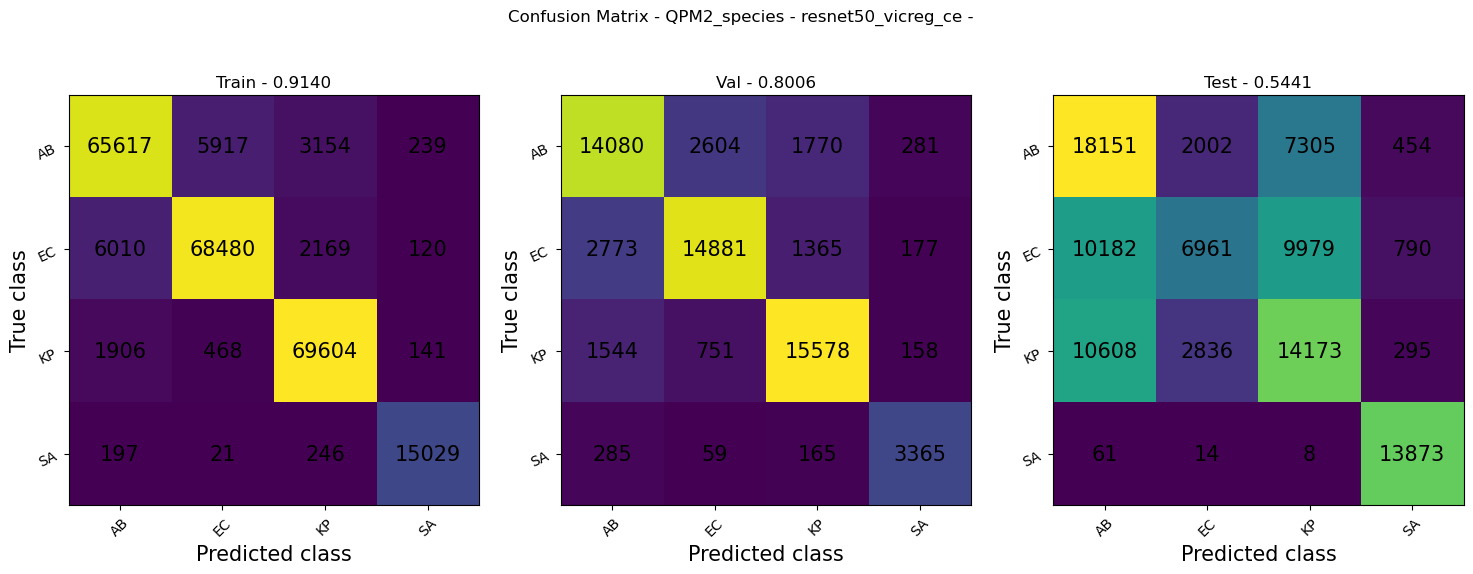

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


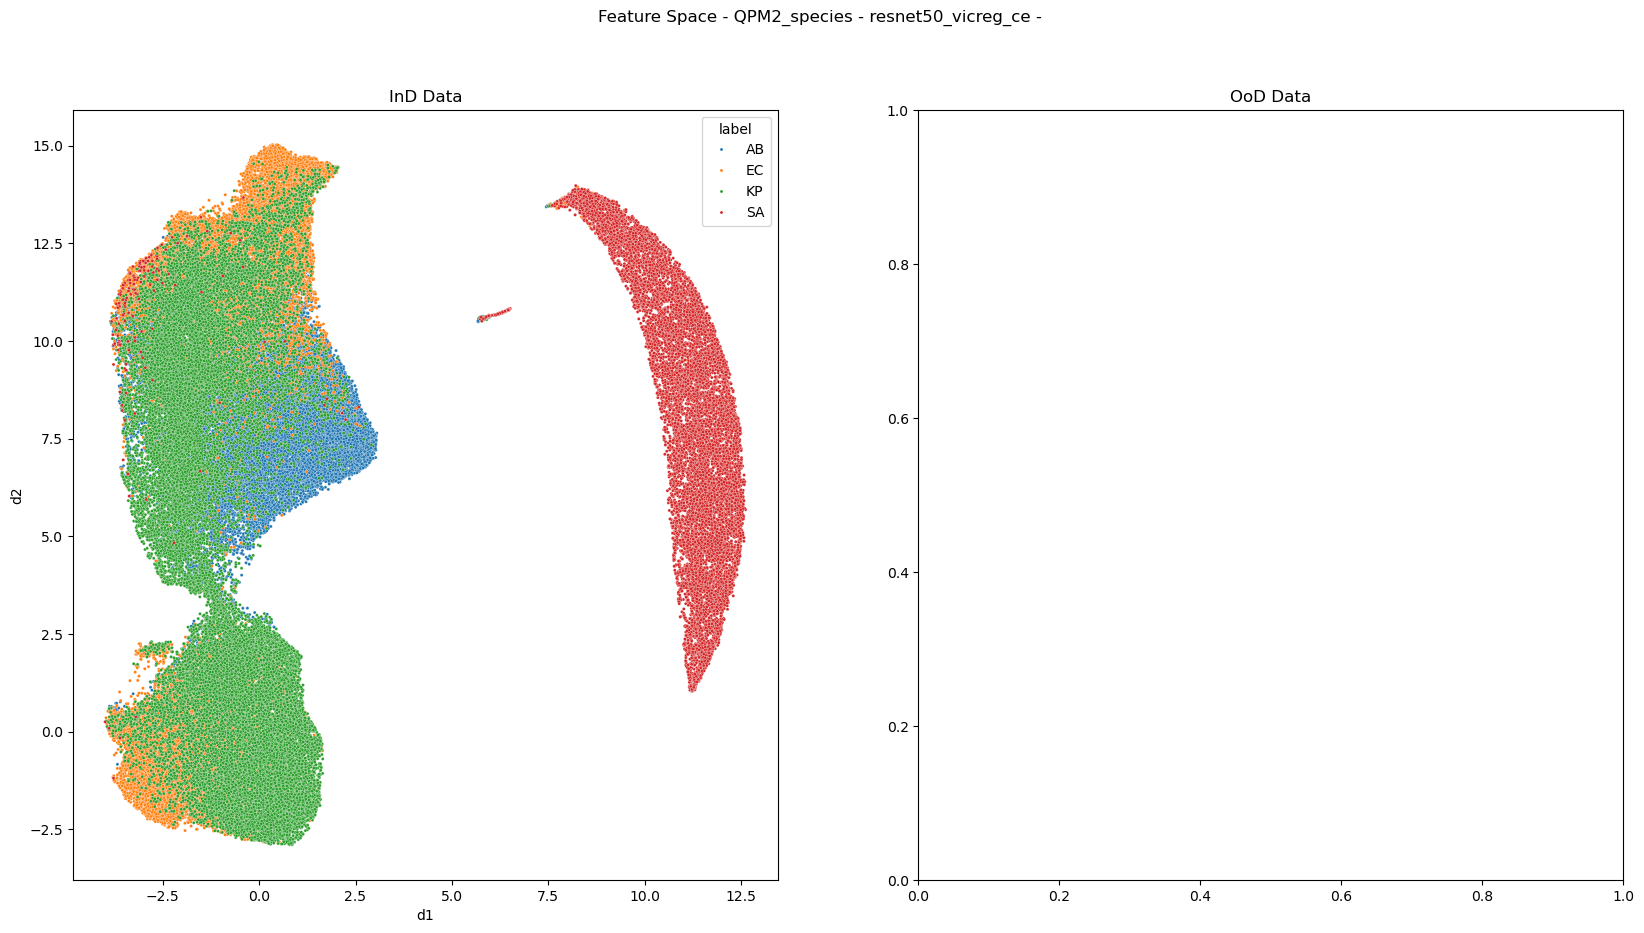

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

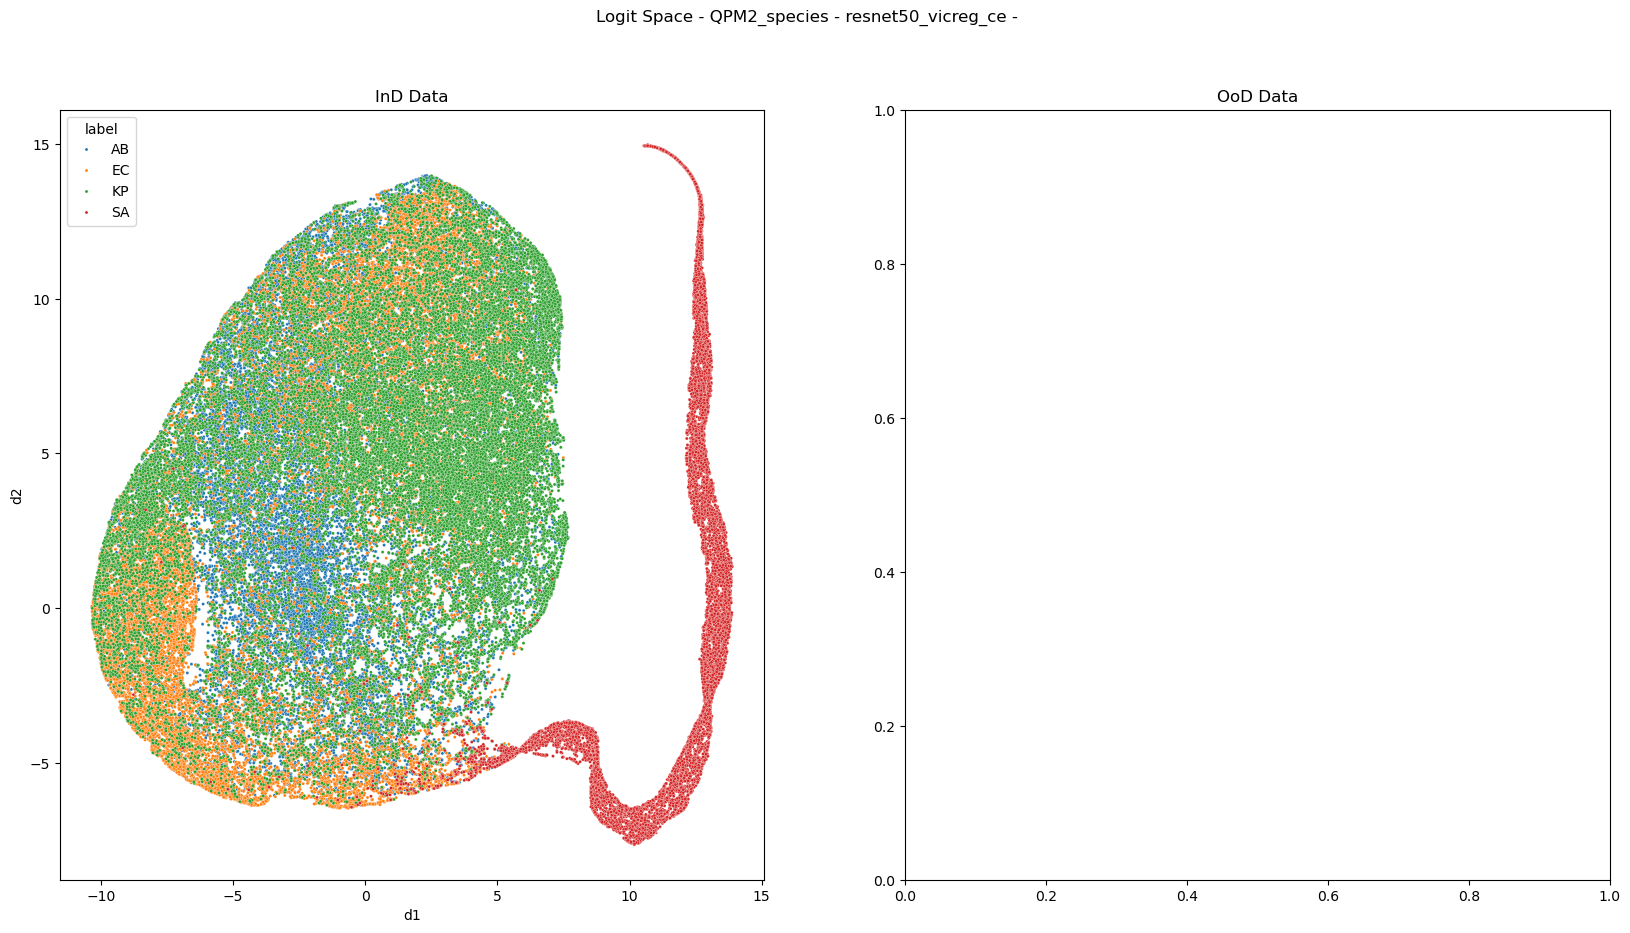

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

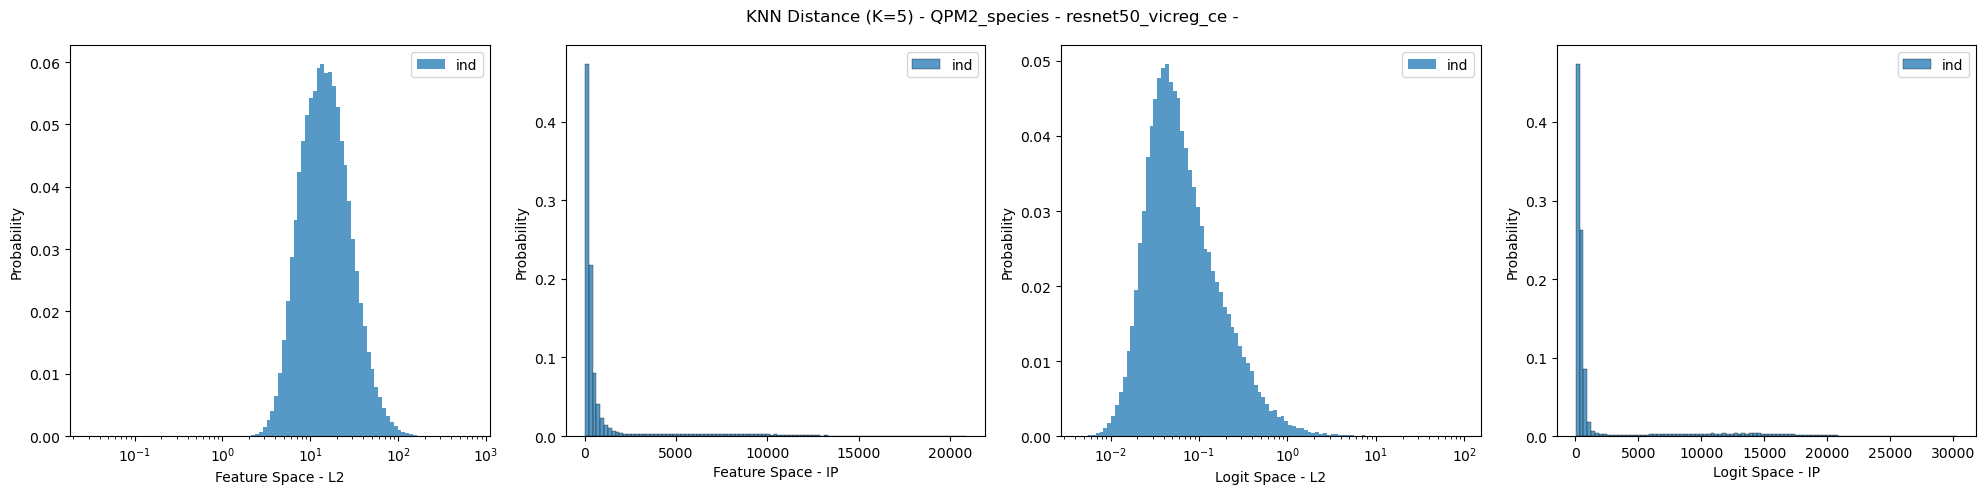

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

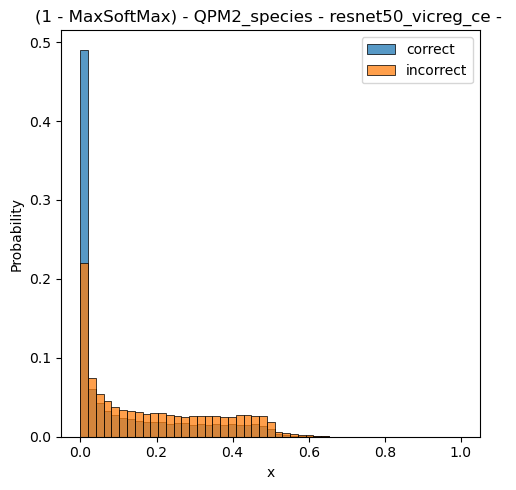

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)